Use machine learning techniques to evaluates the likelihood that an area will inundate (flood) or dynamically respond (adapt) to sea-level rise

Sea-level rise (SLR) is a major threat to natural and built environments around the world and understanding SLR-induced hazards is essential for coastal planning purposes. Projecting the impacts of rising seas is a complex and inherently uncertain problem but, in order to make sustainable management plans, decision-makers need to be presented with accurate and easy to utilize and visualize tools to allow them to assess sea-level rise scenarios and risks. This project, in collaboration with the Inception Institute of Artificial intelligence (IIAI), aims to identify the coastal response to SLR, to guide coastal resource management decisions regarding future SLR impacts and uncertainty against ecological targets and economic constraints.

### Importing the required modules

In [1]:
import copy
import collections
import math
import pandas as pd
import numpy as np

import geopandas as gpd
from osgeo import osr, gdal
import georasters as gr
import rasterio
import pyproj
from rasterio.plot import show


from scipy.interpolate import griddata
import pgmpy.models
import pgmpy.inference
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import ParameterEstimator
from pgmpy.inference import VariableElimination
import networkx as nx

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
sns.set_theme(style="darkgrid")

/opt/anaconda3/envs/SLResearch/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.1-CAPI-1.13.3) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


### Reading the files to load the data


In [2]:
vlm_df = pd.read_excel('Data/data_analisis.xls')

elevation_file = gr.from_file('Data/Elevation.TIF')
elevation_df = elevation_file.to_geopandas()
dataset = rasterio.open('Data/Elevation.tif')
elevation = dataset.read(1)

slr_df = pd.read_excel('Data/SLR-A.xls', skiprows=15)

#note: the Elevation-Habitat map does not need to be read because it will be created and used in this notebook

# Interpolation of VLM Data:

In [3]:
vlm = vlm_df.drop(columns=['Station', 'VLM_std'])

In [4]:
# Boundary points
# Top point: max latitude
top = vlm.iloc[vlm.idxmax().Latitude]
# Bottom point: min latitude
bottom = vlm.iloc[vlm.idxmin().Latitude]
# Left point: min longitude
left = vlm.iloc[vlm.idxmin().Longitude]
# Right point: max longitude
right = vlm.iloc[vlm.idxmax().Longitude]

In [5]:
# Artificial points for calculating distances
# point = (lon, lat)
# Top counter: lon = top, lat = bottom
top_counter = (top.Longitude, bottom.Latitude)
# Bottom counter: lon = bottom, lat = top
bottom_counter = (bottom.Longitude, top.Latitude)
# Left counter: lon = right, lat = left
left_counter = (right.Longitude, left.Latitude)
# Right counter: lon = left, lat = right
right_counter = (left.Longitude, right.Latitude)

In [6]:
# Arrays for plotting
top_pair = (np.array([top.Longitude, top_counter[0]]), np.array([top.Latitude, top_counter[1]]))
bottom_pair = (np.array([bottom.Longitude, bottom_counter[0]]), np.array([bottom.Latitude, bottom_counter[1]]))
left_pair = (np.array([left.Longitude, left_counter[0]]), np.array([left.Latitude, left_counter[1]]))
right_pair = (np.array([right.Longitude, right_counter[0]]), np.array([right.Latitude, right_counter[1]]))

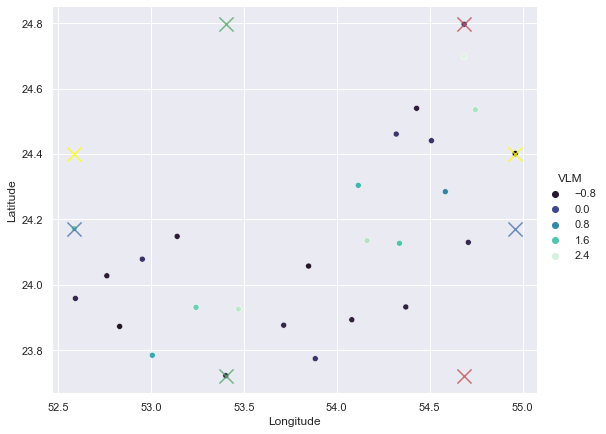

In [7]:
sns.relplot(x="Longitude", y="Latitude", hue="VLM", data=vlm, palette="mako", height=6, aspect=1.25)
plt.scatter(top_pair[0], top_pair[1], c='r', marker='x', s=200, alpha=0.8)
plt.scatter(bottom_pair[0], bottom_pair[1], c='g', marker='x', s=200, alpha=0.8)
plt.scatter(left_pair[0], left_pair[1], c='b', marker='x', s=200, alpha=0.8)
plt.scatter(right_pair[0], right_pair[1], c='yellow', marker='x', s=200, alpha=0.8)

In [8]:
from math import radians, cos, sin, asin, sqrt
def distance(lon1, lat1, lon2, lat2):
     
    # The math module contains a function named
    # radians which converts from degrees to radians.
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
      
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
 
    c = 2 * asin(sqrt(a))
    
    # Radius of earth in meters. Use 3956 for miles
    r = 6371*1000
      
    # calculate the result
    return(c * r)

In [9]:
# Distances of vertical pairs (top & bottom)
ver_top = distance(top.Longitude, top.Latitude, top_counter[0], top_counter[1])
ver_bottom = distance(bottom.Longitude, bottom.Latitude, bottom_counter[0], bottom_counter[1])
# Distances of horizontal pairs (left & right)
hor_left = distance(left.Longitude, left.Latitude, left_counter[0], left_counter[1])
hor_right = distance(right.Longitude, right.Latitude, right_counter[0], right_counter[1])

In [10]:
# There is some slight difference so I'm taking the rounded mean values
dis_ver = np.ceil(np.mean((ver_top, ver_bottom)))
dis_hor = np.ceil(np.mean((hor_left, hor_right)))

In [11]:
# Boundary values
x_min, x_max = vlm.min().Longitude, vlm.max().Longitude
y_min, y_max = vlm.min().Latitude, vlm.max().Latitude

In [12]:
# Divide by distance of 10m seems a bit too detailed. Trying with adding points every 100m instead
nx, ny = (np.int(np.ceil(dis_ver / 100)), np.int(np.ceil(dis_hor / 100)))
x = np.linspace(x_min, x_max, nx)
y = np.linspace(y_min, y_max, ny)
xv, yv = np.meshgrid(x, y)

<ipython-input-12-9eeb23183f3a>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  nx, ny = (np.int(np.ceil(dis_ver / 100)), np.int(np.ceil(dis_hor / 100)))


In [13]:
vlm_points = vlm[['Longitude', 'Latitude']].values
vlm_values = vlm.VLM.values

In [14]:
vlm_grid = griddata(vlm_points, vlm_values, (xv, yv), method='cubic')

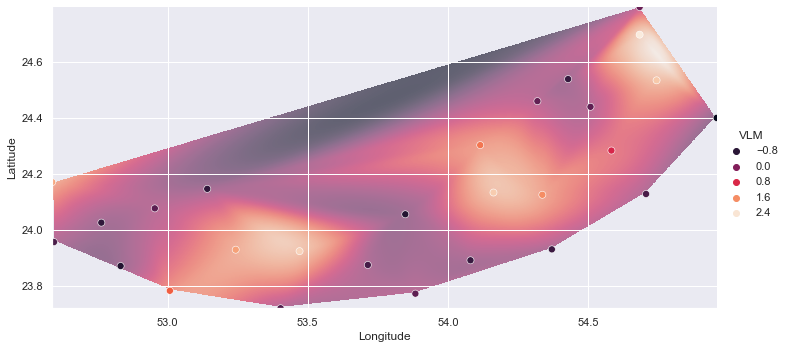

In [15]:
sns.relplot(x="Longitude", y="Latitude", hue="VLM", data=vlm, s=50, palette="rocket", height=10)
plt.imshow(vlm_grid, extent=(x_min, x_max, y_min, y_max), origin='lower', alpha=0.6)
plt.show()

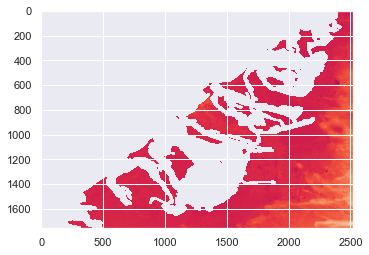

In [16]:
elevation_new = copy.deepcopy(elevation)

elevation_new = elevation_new.astype('float')
elevation_new[elevation_new == 32767] = np.nan

plt.imshow(elevation_new)

Idea: flatten the coordinate grid into pairs of coordinates to use as inputs for another interpolation

In [17]:
vlm_inter_points = np.hstack((xv.reshape(-1, 1), yv.reshape(-1, 1)))

In [18]:
vlm_inter_values = vlm_grid.flatten()

In [19]:
elev_coor = elevation_df[['x', 'y']].values

In [20]:
elev_grid_0 = griddata(vlm_points, vlm_values, elev_coor, method='cubic') # without pre-interpolation
elev_grid_1 = griddata(vlm_inter_points, vlm_inter_values, elev_coor, method='cubic') # with pre-interpolation

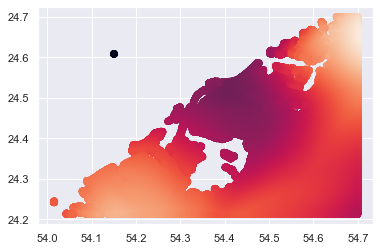

In [21]:
plt.scatter(x=elevation_df.x, y=elevation_df.y, c=elev_grid_0)

In [22]:
# Find elevation map boundaries
x_min_elev = dataset.bounds.left
x_max_elev = dataset.bounds.right
y_min_elev = dataset.bounds.bottom
y_max_elev = dataset.bounds.top

# Create elevation meshgrid
nyy, nxx = elevation_new.shape
xx = np.linspace(x_min_elev, x_max_elev, nxx)
yy = np.linspace(y_min_elev, y_max_elev, nyy)
xxv, yyv = np.meshgrid(xx, yy)

xxv.shape, yyv.shape

((1758, 2521), (1758, 2521))

elev_grid = griddata(vlm_inter_points, vlm_inter_values, (xxv, yyv), method='linear')

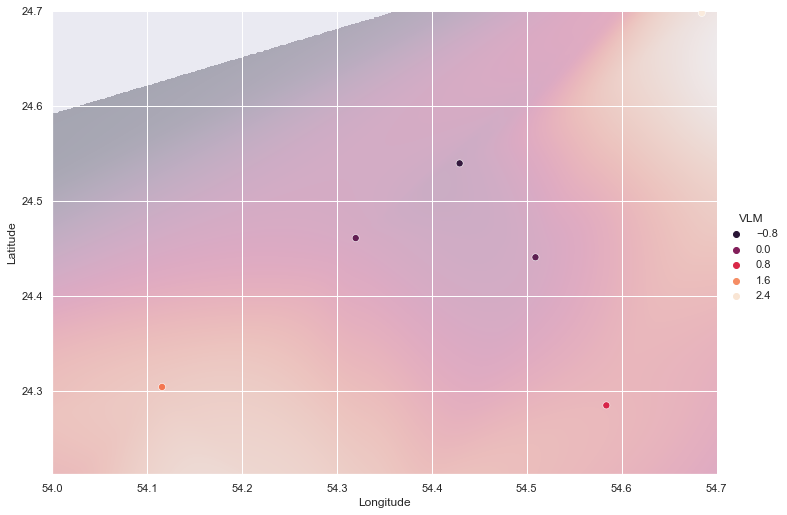

In [23]:
sns.relplot(x="Longitude", y="Latitude", hue="VLM", data=vlm, s=50, palette="rocket", height=10)
plt.imshow(elev_grid, extent=(x_min_elev, x_max_elev, y_min_elev, y_max_elev), origin="lower", alpha=0.3)
plt.show()

In [24]:
elev_grid_copy = copy.deepcopy(elev_grid)

In [25]:
elev_grid_copy[np.isnan(np.flip(elevation_new, 0))] = np.nan
# Needs to flip elevation array vertically. I don't really understand why.

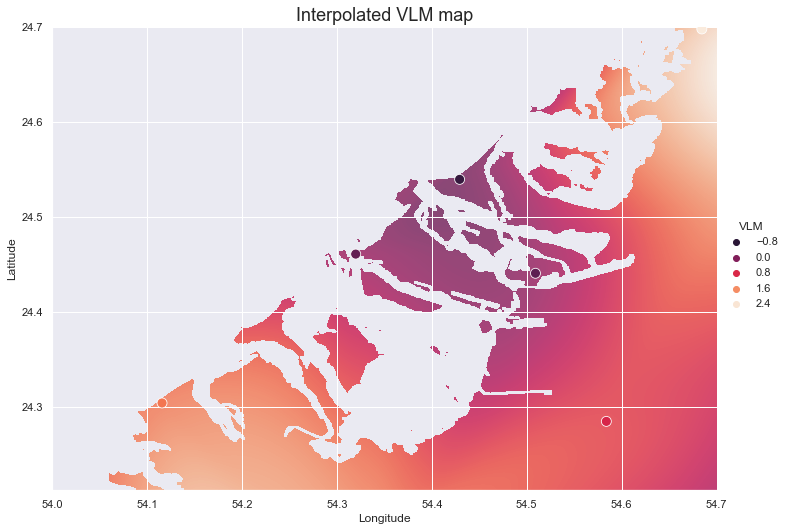

In [26]:
sns.relplot(x="Longitude", y="Latitude", hue="VLM", data=vlm, s=100, edgecolor="white", palette="rocket", height=10)
plt.imshow(elev_grid_copy, extent=(x_min_elev, x_max_elev, y_min_elev, y_max_elev), origin='lower', alpha=0.8)
fontprops = fm.FontProperties(size=18)
plt.title("Interpolated VLM map", fontproperties=fontprops)

#Add North arrow
# x1, y1, arrow_length = 0.05, 0.95, 0.1
# plt.annotate('N', xy=(x1, y1), xytext=(x1, y1-arrow_length),
#             arrowprops=dict(facecolor='black', width=5, headwidth=15),
#             ha='center', va='center', fontsize=20)

plt.show()

### **the interpolated VLM values are stored in: elev_grid_copy

## Calculating Adjusted Elevation:

### For the year 2100

In [27]:
# slr_new = slr_df.loc[(slr_df.Scenario == '0.3 - LOW') |  (slr_df.Scenario == '2.5 - HIGH')]
# RSL in 2100 (cm)
# slr_new['SL'] = slr_new.iloc[:,16]

<ipython-input-27-84dab790276a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slr_new['SL'] = slr_new.iloc[:,16]


In [28]:
# slr_new

,Site,PSMSL ID,Latitude,Longitude,Scenario,Background RSL rate (mm/yr),RSL in 2000 (cm),RSL in 2010 (cm),RSL in 2020 (cm),RSL in 2030 (cm),...,RSL in 2050 (cm),RSL in 2060 (cm),RSL in 2070 (cm),RSL in 2080 (cm),RSL in 2090 (cm),RSL in 2100 (cm),RSL in 2120 (cm),RSL in 2150 (cm),RSL in 2200 (cm),SL
1,NEW YORK,12,54.080777,23.8926,0.3 - LOW,1.20,0,2,6,10,...,15,18,19,21,21,22,27,28,26,22
17,NEW YORK,12,54.080777,23.8926,2.5 - HIGH,1.38,0,15,33,55,...,114,150,194,241,296,357,530,772,1237,357


In [29]:
ae_low = copy.deepcopy(elev_grid_copy)
ae_high = copy.deepcopy(elev_grid_copy)

In [68]:
# Division by 100 to fix unit difference
ae_low = np.flip(elevation_new, 0) - 0.49/100 + ae_low/1000
ae_high = np.flip(elevation_new, 0) - 0.83/100 + ae_high/1000
ae_high

array([[        nan,         nan,         nan, ..., 37.02876218,
        38.02976418, 39.03076617],
       [        nan,         nan,         nan, ..., 38.02976418,
        39.03076618, 40.03176818],
       [        nan,         nan,         nan, ..., 39.03076618,
        38.02976418, 38.02976418],
       ...,
       [        nan,         nan,         nan, ..., -3.01131529,
        -4.01231729, -4.01231729],
       [        nan,         nan,         nan, ..., -3.01131529,
        -4.01231729, -6.01432129],
       [        nan,         nan,         nan, ..., -2.0103133 ,
        -4.0123173 , -4.01231729]])

In [65]:
ae_min = min(ae_low[~np.isnan(ae_low)].min(), ae_high[~np.isnan(ae_high)].min())
ae_max = max(ae_low[~np.isnan(ae_low)].max(), ae_high[~np.isnan(ae_high)].max())

Text(0.5, 1.0, 'Map of adjusted elevation for high year 2100')

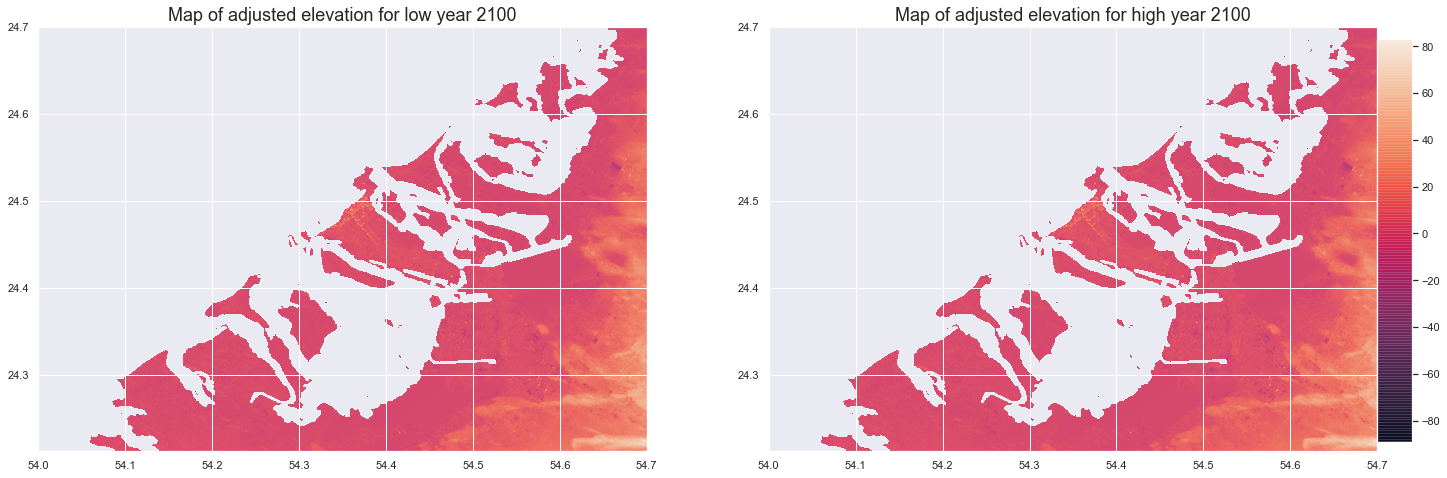

In [66]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(24, 8))
im1 = ax1.imshow(ae_low, extent=(x_min_elev, x_max_elev, y_min_elev, y_max_elev), origin='lower', alpha=0.8, vmin=ae_min, vmax=ae_max)
im2 = ax2.imshow(ae_high, extent=(x_min_elev, x_max_elev, y_min_elev, y_max_elev), origin='lower', alpha=0.8, vmin=ae_min, vmax=ae_max)
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
fig.colorbar(im2, cax=cbar_ax)
ax1.set_title("Map of adjusted elevation for low year 2100", fontproperties=fontprops)
ax2.set_title("Map of adjusted elevation for high year 2100", fontproperties=fontprops)


# #Add North arrow
# x1, y1, arrow_length = 0.05, 0.95, 0.1
# ax1.annotate('N', xy=(x1, y1), xytext=(x1, y1-arrow_length),
#             arrowprops=dict(facecolor='black', width=5, headwidth=15),
#             ha='center', va='center', fontsize=20)
# ax2.annotate('N', xy=(x1, y1), xytext=(x1, y1-arrow_length),
#             arrowprops=dict(facecolor='black', width=5, headwidth=15),
#             ha='center', va='center', fontsize=20)

### **the adjusted values are stored in: ae_high and ae_low

## Elevation-Habitat Map:

## Habitats Grouping:

In [33]:
# **This needs to be re-checked to read the proper final map not'Data/Final_Combined2.shp'
elev_habit_map = gpd.read_file('New_Map/Final_Combined2.shp')
print(type(elev_habit_map))

<class 'geopandas.geodataframe.GeoDataFrame'>


In [34]:
# Create New Column for New Habitat Groups:
elev_habit_map['Habitat_Groups'] = ''
elev_habit_map.head(1)

,OBJECTID,Id,HabitatTyp,HabitatT_1,HabitatSub,HabitatS_1,RuleID,Shape_Leng,Shape_Area,Habitats,geometry,Habitat_Groups
0,25179,25183,9000,"Urban, Industrial And Commercial Habitat Types",9230,Port Areas,49,6946.566553,656876.971787,Developed,POINT (54.65181 24.70014),


In [35]:
np.unique(elev_habit_map.Habitats)

array(['Coastal Rocky Plains', 'Coastal Salt Flats',
       'Coastal Sand Plains', 'Coral Reefs', 'Deep Sub-Tidal Seabed',
       'Developed', 'Dredged Area Wall', 'Dredged Seabed', 'Farmland',
       'Forest Plantations', 'Gravel Plains', 'Hard-Bottom',
       'Intertidal Habitats', 'Lakes or Artificial Lakes', 'Mangroves',
       'Marine Structure', 'Mountains', 'Saltmarsh',
       'Sand Sheets and Dunes', 'Sandy Beaches', 'Seagrass Bed',
       'Unconsolidated Bottom', 'Wetlands'], dtype=object)

### Setting up the habitats grouping

In [36]:
elev_habit_map.loc[ (elev_habit_map.Habitats == 'Marine Structure')
                   | (elev_habit_map.Habitats == 'Developed')
                   | (elev_habit_map.Habitats == 'Dredged Area Wall') 
                   | (elev_habit_map.Habitats == 'Dredged Seabed')
                   | (elev_habit_map.Habitats == 'Farmland') 
                   , 'Habitat_Groups'] = 'Developed'

In [37]:
elev_habit_map.loc[ (elev_habit_map.Habitats == 'Mountains')
                   | (elev_habit_map.Habitats == 'Coastal Cliff')
                   | (elev_habit_map.Habitats == 'Coastal Rocky Plains') 
                   | (elev_habit_map.Habitats == 'Gravel Plains')
                   | (elev_habit_map.Habitats == 'Rock Armouring / Artificial Reef') 
                   | (elev_habit_map.Habitats == 'Rocky Beaches')
                   | (elev_habit_map.Habitats == 'Storm Beach Ridges') 
                   , 'Habitat_Groups'] = 'Rocky'

In [38]:
elev_habit_map.loc[ (elev_habit_map.Habitats == 'Mega Dunes')
                   | (elev_habit_map.Habitats == 'Sand Sheets and Dunes')
                   | (elev_habit_map.Habitats == 'Sandy Beaches')
                   | (elev_habit_map.Habitats == 'Coastal Sand Plains')
                   , 'Habitat_Groups'] = 'Sandy'

In [39]:
elev_habit_map.loc[ (elev_habit_map.Habitats == 'Coastal Salt Flats')
                   | (elev_habit_map.Habitats == 'Inland Salt Flats')
                   | (elev_habit_map.Habitats == 'Saltmarsh')
                   | (elev_habit_map.Habitats == 'Intertidal Habitats')
                   | (elev_habit_map.Habitats == 'Wetlands')
                   , 'Habitat_Groups'] = 'Marsh/Salt Flats'

In [40]:
elev_habit_map.loc[ (elev_habit_map.Habitats == 'Coral Reefs')
                   | (elev_habit_map.Habitats == 'Deep Sub-Tidal Seabed')
                   | (elev_habit_map.Habitats == 'Hard-Bottom') 
                   | (elev_habit_map.Habitats == 'Seagrass Bed')
                   | (elev_habit_map.Habitats == 'Lakes or Artificial Lakes')
                   | (elev_habit_map.Habitats == 'Unconsolidated Bottom')
                   , 'Habitat_Groups'] = 'Subaqueous'

In [41]:
elev_habit_map.loc[ (elev_habit_map.Habitats == 'Forest Plantations')
                   | (elev_habit_map.Habitats == 'Mangroves') 
                   , 'Habitat_Groups'] = 'Forest'

In [42]:
unique_groups = np.unique(elev_habit_map.Habitat_Groups)
print(unique_groups)
print(len(unique_groups))


['Developed' 'Forest' 'Marsh/Salt Flats' 'Rocky' 'Sandy' 'Subaqueous']
6


### **The Elev-Habit DF now has habitat groups & it is called: 'elev_habit_map'

## VLM Bins & Habitat Classes:

### 1. VLM Bins:

In [43]:
print(elev_grid_copy, len(elev_grid_copy))

print(type(elev_grid_copy))
print(type(elev_grid_copy.flatten()))
elev_grid_copy.flatten()

[[       nan        nan        nan ... 0.05710217 0.05500431 0.05290645]
 [       nan        nan        nan ... 0.05865274 0.05655488 0.05445702]
 [       nan        nan        nan ... 0.06020227 0.05810664 0.05601002]
 ...
 [       nan        nan        nan ... 2.58897781 2.59066025 2.59236938]
 [       nan        nan        nan ... 2.58487221 2.58655464 2.58823708]
 [       nan        nan        nan ... 2.58071978 2.58240221 2.58408464]] 1758
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


array([       nan,        nan,        nan, ..., 2.58071978, 2.58240221,
       2.58408464])

In [44]:
# Dropping the NaN values in the array:
nan_array = np.isnan(elev_grid_copy.flatten())
not_nan_array = ~ nan_array
vlm_interpolated_arr = elev_grid_copy.flatten()[not_nan_array]
vlm_interpolated_arr

array([1.16874389, 1.17216239, 1.17560947, ..., 2.58071978, 2.58240221,
       2.58408464])

### **The clean, flattened VLM array for interpolated VLM values is called:   'vlm_interpolated_arr'

In [45]:
# Step 1: Making 3 equal-size bins for VLM data: note: interval differences are irrelevant 

vlm_bins = pd.qcut(vlm_interpolated_arr, q=3, precision=1, labels=['Bin #1', 'Bin #2', 'Bin #3'])

# bin definition
bins  = vlm_bins.categories
print(bins)
# bin corresponding to each point in data
codes = vlm_bins.codes
print(np.unique(codes))

Index(['Bin #1', 'Bin #2', 'Bin #3'], dtype='object')
[0 1 2]


Counter({2: 596554, 0: 596554, 1: 596553})
   Bin Index  Frequency
0          2     596554
1          0     596554
2          1     596553


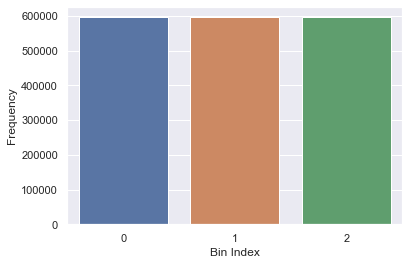

In [46]:
# Step 2: Making Sure that the Bins are of Almost Equal Size:
size = collections.Counter(codes)
print(size)

d_table = pd.value_counts(codes).to_frame(name='Frequency')
d_table = d_table.reset_index()
d_table = d_table.rename(columns={'index': 'Bin Index'})
fig, ax = plt.subplots()
sns.barplot(x="Bin Index", y="Frequency", data=d_table, label="Size of Each of the 3 Bins", ax=ax)
print(d_table)

In [47]:
# Step 3: Calculating Probability of each Bin:
prob0 = 100 * (d_table.loc[0].Frequency)/len(vlm_interpolated_arr)
prob1 = 100 * (d_table.loc[1].Frequency)/len(vlm_interpolated_arr)
prob2 = 100 * (d_table.loc[2].Frequency)/len(vlm_interpolated_arr)
print(prob0, prob1, prob2)

33.33335195883466 33.33335195883466 33.333296082330676


In [48]:
# Step 4: Joining Everything in a Single Data Frame for aesthetic:
vlm_bins_df = pd.DataFrame()

vlm_bins_df['VLM Values'] = vlm_interpolated_arr
vlm_bins_df['Bins'] = vlm_bins
vlm_bins_df['Intervals'] = pd.qcut(vlm_interpolated_arr, q=3, precision=1)

vlm_bins_df['Probability'] = ''
vlm_bins_df.loc[ (vlm_bins_df.Bins == 'Bin #1'), 'Probability'] = prob0
vlm_bins_df.loc[ (vlm_bins_df.Bins == 'Bin #2'), 'Probability'] = prob1
vlm_bins_df.loc[ (vlm_bins_df.Bins == 'Bin #3'), 'Probability'] = prob2

vlm_bins_df.head()

,VLM Values,Bins,Intervals,Probability
0,1.168744,Bin #3,"(1.0, 2.9]",33.3333
1,1.172162,Bin #3,"(1.0, 2.9]",33.3333
2,1.175609,Bin #3,"(1.0, 2.9]",33.3333
3,1.179118,Bin #3,"(1.0, 2.9]",33.3333
4,1.182627,Bin #3,"(1.0, 2.9]",33.3333


### 2. Habitat Classes:

In [49]:
# Step 1: Create Data Frame:
elevation_classes = pd.DataFrame()
elevation_classes['Elevation_Values'] = elevation_df.value

In [50]:
# Step 2: Get Max and Min Values for Elevation
min_elev = elevation_df.value.min()
max_elev = elevation_df.value.max()

In [51]:
# Step 3: Create Intervals:
interval_0 = pd.cut(x=elevation_df['value'], bins=[1, 5, 10, max_elev])
interval_1 = pd.cut(x=elevation_df['value'], bins=[min_elev, -10, -1, 0], right=False)
interval_2 = pd.cut(x=elevation_df['value'], bins=[0, 1], include_lowest=True)

In [52]:
# Step 4: Add intervals to dataframe:
elevation_classes['Intervals_0'] = interval_0
elevation_classes['Intervals_1'] = interval_1
elevation_classes['Intervals_2'] = interval_2
elevation_classes['Intervals'] = ''

elevation_classes.loc[ ((elevation_classes.Intervals_0.isnull()) & (elevation_classes.Intervals_1.isnull())), 'Intervals'] = interval_2
elevation_classes.loc[ ((elevation_classes.Intervals_0.isnull()) & (elevation_classes.Intervals_2.isnull())), 'Intervals'] = interval_1
elevation_classes.loc[ ((elevation_classes.Intervals_1.isnull()) & (elevation_classes.Intervals_2.isnull())), 'Intervals'] = interval_0

elevation_classes.drop(['Intervals_2', 'Intervals_1', 'Intervals_0'], axis='columns', inplace=True)

Counter({Interval(1.0, 5.0, closed='right'): 603235, Interval(10.0, 83.0, closed='right'): 409264, Interval(-0.001, 1.0, closed='right'): 389632, Interval(5.0, 10.0, closed='right'): 231449, Interval(-1.0, 0.0, closed='left'): 77165, Interval(-10.0, -1.0, closed='left'): 76021, Interval(-89.0, -10.0, closed='left'): 2895})
      Class Index  Frequency
0      (1.0, 5.0]     603235
1    (10.0, 83.0]     409264
2   (-0.001, 1.0]     389632
3     (5.0, 10.0]     231449
4     [-1.0, 0.0)      77165
5   [-10.0, -1.0)      76021
6  [-89.0, -10.0)       2895


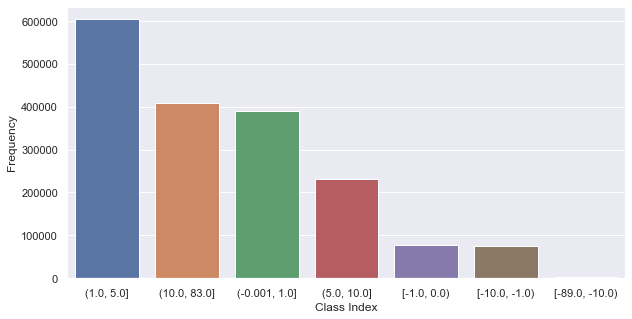

In [53]:
# Step 5: Plotting the Size of Each Interval:
size = collections.Counter(elevation_classes.Intervals)
print(size)

d_table_elev = pd.value_counts(elevation_classes.Intervals).to_frame(name='Frequency')
d_table_elev = d_table_elev.reset_index()
d_table_elev = d_table_elev.rename(columns={'index': 'Class Index'})
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x="Class Index", y="Frequency", data=d_table_elev, label="Size of Each Class", ax=ax)
print(d_table_elev)

In [54]:
# Step 6: Calculate Probabilities:
prob0_elev = 100 * (d_table_elev.loc[6].Frequency)/len(elevation_classes)   # [min_elev, -10)
prob1_elev = 100 * (d_table_elev.loc[5].Frequency)/len(elevation_classes)   # [-10, -1)
prob2_elev = 100 * (d_table_elev.loc[4].Frequency)/len(elevation_classes)   # [-1, 0)
prob3_elev = 100 * (d_table_elev.loc[2].Frequency)/len(elevation_classes)   # [0, 1]
prob4_elev = 100 * (d_table_elev.loc[0].Frequency)/len(elevation_classes)   # (1, 5]
prob5_elev = 100 * (d_table_elev.loc[3].Frequency)/len(elevation_classes)   # (5, 10]
prob6_elev = 100 * (d_table_elev.loc[1].Frequency)/len(elevation_classes)   # (10, max_elev]

print(prob0_elev, prob1_elev, prob2_elev, prob3_elev, prob4_elev, prob5_elev, prob6_elev)

0.16176247903932645 4.247787709515936 4.3117104300758635 21.771274001053833 33.706662881964796 12.932560971044238 22.868241527306008


In [55]:
# Step 7: Adding probabilities to d_table_elev for visualization:
d_table_elev['Probability'] = ''
d_table_elev['Probability'].loc[0] = prob4_elev
d_table_elev['Probability'].loc[1] = prob6_elev
d_table_elev['Probability'].loc[2] = prob3_elev
d_table_elev['Probability'].loc[3] = prob5_elev
d_table_elev['Probability'].loc[4] = prob2_elev
d_table_elev['Probability'].loc[5] = prob1_elev
d_table_elev['Probability'].loc[6] = prob0_elev
d_table_elev

/opt/anaconda3/envs/SLResearch/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Class Index,Frequency,Probability
0,"(1.0, 5.0]",603235,33.7067
1,"(10.0, 83.0]",409264,22.8682
2,"(-0.001, 1.0]",389632,21.7713
3,"(5.0, 10.0]",231449,12.9326
4,"[-1.0, 0.0)",77165,4.31171
5,"[-10.0, -1.0)",76021,4.24779
6,"[-89.0, -10.0)",2895,0.161762


## BN Model:

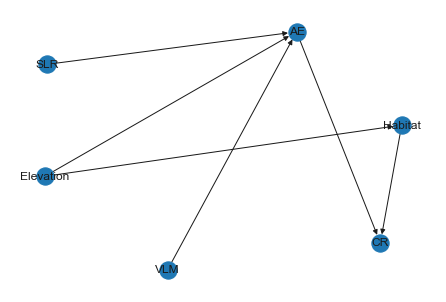

In [56]:
# Build the network:
import networkx as nx


model = pgmpy.models.BayesianModel([('SLR', 'AE'), ('VLM', 'AE'), ('Elevation', 'AE'), ('Elevation', 'Habitat'), ('Habitat', 'CR'), ('AE', 'CR')])
nx.draw(model, with_labels=True)

In [57]:
# CPD for SLR
cpd_slr = pgmpy.factors.discrete.TabularCPD('SLR', 4, [[0.25], [0.25], [0.25], [0.25]], state_names={'SLR': ['0-0.25', '0.25-0.5', '0.5-0.75', '0.75-2']})

In [58]:
# CPD for VLM: note: I have initially set the probabilities to 0.33
cpd_vlm = pgmpy.factors.discrete.TabularCPD('VLM', 3, [[prob0], [prob1], [prob2]], state_names={'VLM': ['Bin 1', 'Bin 2', 'Bin 3']})

In [59]:
# CPD for Elevation:
cpd_elevation = pgmpy.factors.discrete.TabularCPD('Elevation', 7, [[prob0_elev], [prob1_elev], [prob2_elev], [prob3_elev], [prob4_elev], [prob5_elev], [prob6_elev]], state_names={'Elevation': ['[min_elev, -10)', '[-10, -1)', '[-1, 0)', '[0, 1]', '(1, 5]', '(5, 10]', '(10, max_elev]']})

In [60]:
# cpd_ae = pgmpy.factors.discrete.TabularCPD('AE', 3, [[prob0], [prob1], [prob2]], state_names={'AE': ['Bin 1', 'Bin 2', 'Bin 3']}, evidence=['VLM', 'SLR','Elevation'])

In [61]:
model.add_cpds(cpd_slr, cpd_vlm, cpd_elevation) #,cpd_ae)

In [62]:
model.check_model()

ValueError: No CPD associated with AE

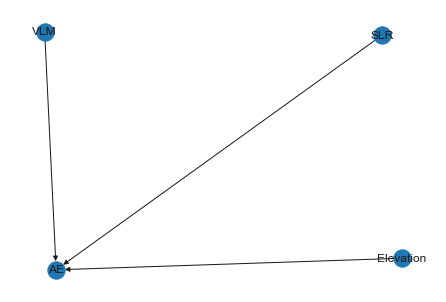

In [69]:
# Build the network:
import networkx as nx


model = pgmpy.models.BayesianModel([('SLR', 'AE'), ('VLM', 'AE'), ('Elevation', 'AE')])
nx.draw(model, with_labels=True)

In [70]:
# CPD for SLR
cpd_slr = pgmpy.factors.discrete.TabularCPD('SLR', 4, [[0.25], [0.25], [0.25], [0.25]], state_names={'SLR': ['0-0.25', '0.25-0.5', '0.5-0.75', '0.75-2']})

In [71]:
# CPD for VLM: note: I have initially set the probabilities to 0.33
cpd_vlm = pgmpy.factors.discrete.TabularCPD('VLM', 3, [[prob0], [prob1], [prob2]], state_names={'VLM': ['Bin 1', 'Bin 2', 'Bin 3']})

In [72]:
# CPD for Elevation:
cpd_elevation = pgmpy.factors.discrete.TabularCPD('Elevation', 7, [[prob0_elev], [prob1_elev], [prob2_elev], [prob3_elev], [prob4_elev], [prob5_elev], [prob6_elev]], state_names={'Elevation': ['[min_elev, -10)', '[-10, -1)', '[-1, 0)', '[0, 1]', '(1, 5]', '(5, 10]', '(10, max_elev]']})

In [73]:
model.add_cpds(cpd_slr, cpd_vlm, cpd_elevation) #,cpd_ae)

In [74]:
model.check_model()

ValueError: No CPD associated with AE